## Microsoft Stock Analysis (Time Series)

In [2]:
#Importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [4]:
# Loading the dataset

data = pd.read_csv('Microsoft_Stock.csv')

# Convert 'Date' column to datetime type

data['Date'] = pd.to_datetime(data['Date'])

# Set 'Date' as the index

data.set_index('Date', inplace=True)
data.head()


,Open,High,Low,Close,Volume
Date,,,,,
2015-04-01 16:00:00,40.60,40.76,40.31,40.72,36865322
2015-04-02 16:00:00,40.66,40.74,40.12,40.29,37487476
2015-04-06 16:00:00,40.34,41.78,40.18,41.55,39223692
2015-04-07 16:00:00,41.61,41.91,41.31,41.53,28809375
2015-04-08 16:00:00,41.48,41.69,41.04,41.42,24753438


### Exploring the dataset

In [7]:
# Displaying first 5 rows

print(data.head())

# Number of rows and columns

print("Shape:", data.shape)

# Summary statistics

print(data.describe())


                      Open   High    Low  Close    Volume
Date                                                     
2015-04-01 16:00:00  40.60  40.76  40.31  40.72  36865322
2015-04-02 16:00:00  40.66  40.74  40.12  40.29  37487476
2015-04-06 16:00:00  40.34  41.78  40.18  41.55  39223692
2015-04-07 16:00:00  41.61  41.91  41.31  41.53  28809375
2015-04-08 16:00:00  41.48  41.69  41.04  41.42  24753438
Shape: (1511, 5)
              Open         High          Low        Close        Volume
count  1511.000000  1511.000000  1511.000000  1511.000000  1.511000e+03
mean    107.385976   108.437472   106.294533   107.422091  3.019863e+07
std      56.691333    57.382276    55.977155    56.702299  1.425266e+07
min      40.340000    40.740000    39.720000    40.290000  1.016120e+05
25%      57.860000    58.060000    57.420000    57.855000  2.136213e+07
50%      93.990000    95.100000    92.920000    93.860000  2.662962e+07
75%     139.440000   140.325000   137.825000   138.965000  3.431962e+07
m

## data Preprocessing

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


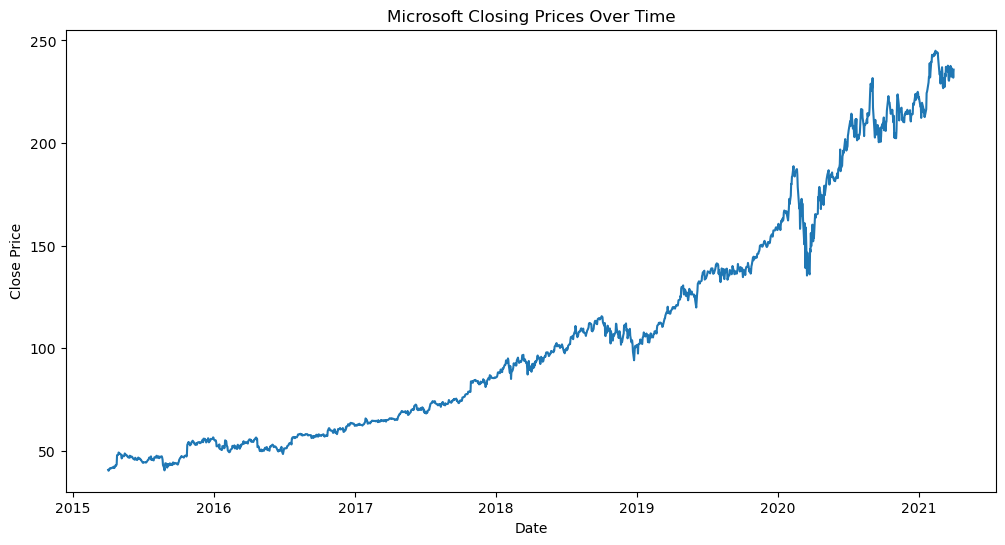

In [10]:
# Checking for missing values

print(data.isnull().sum())

# Handle missing values 

data.ffill(inplace=True)

# Visualize stock price

plt.figure(figsize=(12,6))
plt.plot(data['Close'])
plt.title('Microsoft Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()


### time series decomposition

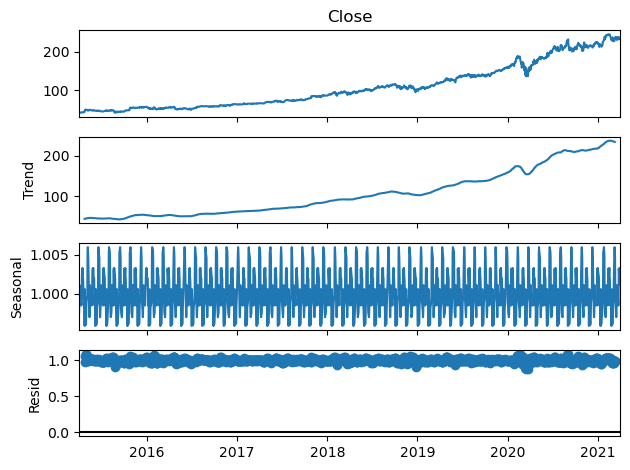

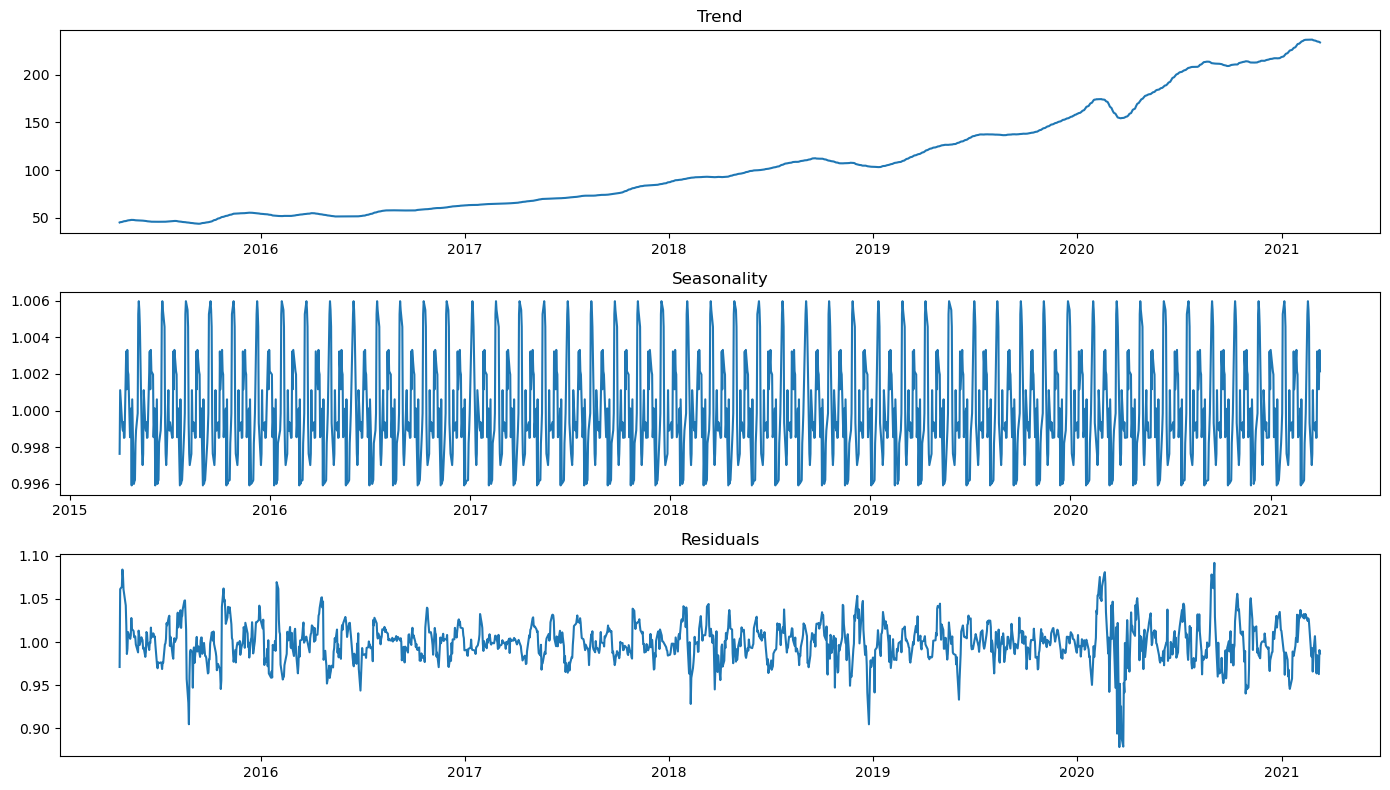

In [13]:
decomposition = seasonal_decompose(data['Close'], model='multiplicative', period=30)
decomposition.plot()
plt.show()

# Accessing components

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot trend, seasonality

plt.figure(figsize=(14,8))
plt.subplot(311)
plt.plot(trend)
plt.title('Trend')
plt.subplot(312)
plt.plot(seasonal)
plt.title('Seasonality')
plt.subplot(313)
plt.plot(residual)
plt.title('Residuals')
plt.tight_layout()
plt.show()


### Spliting data for forcasting

In [16]:
data = data.asfreq('D')
train = data.iloc[:-30]
test = data.iloc[-30:]


### ARIMA Model for Forecasting

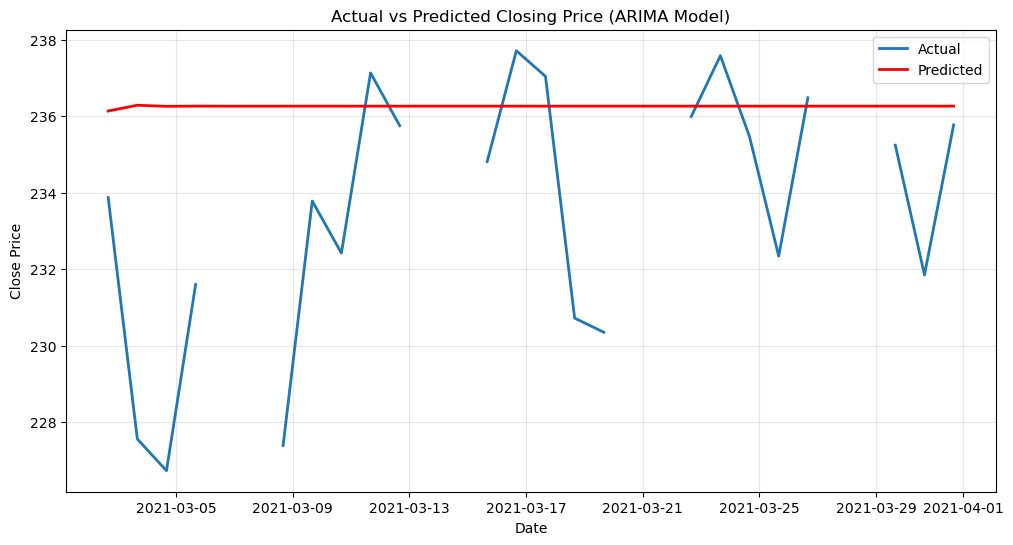

Model Performance Metrics:
RMSE: 4.2822
MAE: 3.1516
MAPE: 1.37%


In [21]:
# AutoRegressive Integrated Moving Average.

model = ARIMA(train['Close'], order=(1,1,1))
model_fit = model.fit()

# Forecasting

forecast = model_fit.forecast(steps=len(test))

# Converting forecast to series with proper index

forecast_series = pd.Series(forecast.values, index=test.index)

# Compare actual vs predicted

plt.figure(figsize=(12,6))
plt.plot(test.index, test['Close'], label='Actual', linewidth=2)
plt.plot(test.index, forecast_series, label='Predicted', color='red', linewidth=2)
plt.legend()
plt.title('Actual vs Predicted Closing Price (ARIMA Model)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True, alpha=0.3)
plt.show()

# Evaluate performance

# Filter out NaN values before computing metrics to avoid ValueError

mask = (~test['Close'].isna()) & (~forecast_series.isna())
test_clean = test['Close'][mask]
forecast_clean = forecast_series[mask]

# Model Evaluation Metric

rmse = np.sqrt(mean_squared_error(test_clean, forecast_clean)) # RMSE (Root Mean Squared Error)
mae = mean_absolute_error(test_clean, forecast_clean) # MAE (Mean Absolute Error)
mape = np.mean(np.abs((test_clean - forecast_clean) / test_clean)) * 100  # MAPE (Mean Absolute Percentage Error)

print(f"Model Performance Metrics:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")

## Analysis and Interpretation

**the ARIMA forecast appear flat**

The ARIMA(1,1,1) model produces a relatively constant prediction because:
1. Basic ARIMA models capture long-term trends and mean-reverting behavior
2. Stock prices exhibit random walk characteristics - making short-term predictions difficult
3. The model is predicting the expected average value rather than capturing volatility

**Model Performance:**
- RMSE: 4.28 (average prediction error)
- MAE: 3.15 (mean absolute error)  
- MAPE: 1.37% (relative percentage error)

These metrics show the model performs reasonably well despite the flat appearance. For better short-term forecasting, we would need:
- More complex models (SARIMA, LSTM, Prophet)
- Additional features (trading volume, market indicators)
- Shorter forecast horizons

## Further Analysis: SARIMA Model

SARIMA (Seasonal ARIMA) extends ARIMA by adding seasonal components.

SARIMA model fitted successfully!


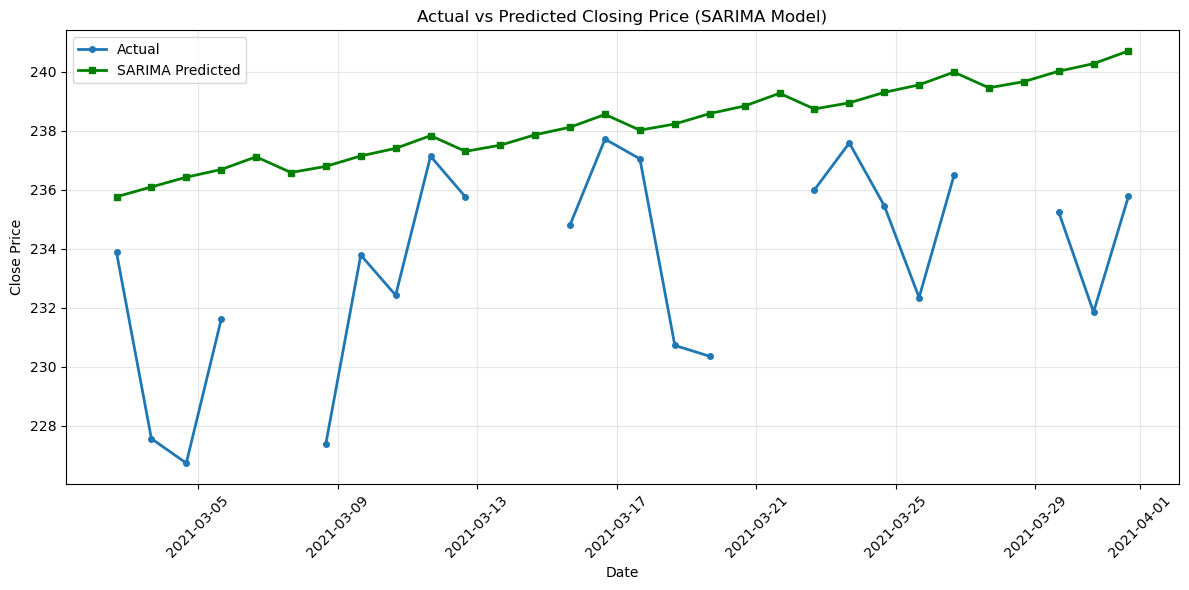


SARIMA Model Performance Metrics:
RMSE: 5.5015
MAE: 4.6709
MAPE: 2.02%


In [27]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fitting SARIMA model

model_sarima = SARIMAX(train['Close'], 
                        order=(1,1,1),
                        seasonal_order=(1,1,1,5), # Seasonality period of 5
                        enforce_stationarity=False,
                        enforce_invertibility=False)

model_sarima_fit = model_sarima.fit(disp=False)
print("SARIMA model fitted successfully!")

# Forecasting

forecast_sarima = model_sarima_fit.forecast(steps=len(test))
forecast_sarima_series = pd.Series(forecast_sarima.values, index=test.index)

# Visualizeing

plt.figure(figsize=(12,6))
plt.plot(test.index, test['Close'], label='Actual', linewidth=2, marker='o', markersize=4)
plt.plot(test.index, forecast_sarima_series, label='SARIMA Predicted', color='green', linewidth=2, marker='s', markersize=4)
plt.legend()
plt.title('Actual vs Predicted Closing Price (SARIMA Model)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Evaluate performance

mask_sarima = (~test['Close'].isna()) & (~forecast_sarima_series.isna())
test_clean_sarima = test['Close'][mask_sarima]
forecast_clean_sarima = forecast_sarima_series[mask_sarima]

rmse_sarima = np.sqrt(mean_squared_error(test_clean_sarima, forecast_clean_sarima))
mae_sarima = mean_absolute_error(test_clean_sarima, forecast_clean_sarima)
mape_sarima = np.mean(np.abs((test_clean_sarima - forecast_clean_sarima) / test_clean_sarima)) * 100

print(f"\nSARIMA Model Performance Metrics:")
print(f"RMSE: {rmse_sarima:.4f}")
print(f"MAE: {mae_sarima:.4f}")
print(f"MAPE: {mape_sarima:.2f}%")

In [29]:
# Model Performance Comparison Table

import pandas as pd

# Collecting metrics from all models (ARIMA and SARIMA )

comparison_data = {
    'Model': ['ARIMA', 'SARIMA'],
    'RMSE': [rmse, rmse_sarima],
    'MAE': [mae, mae_sarima],
    'MAPE (%)': [mape, mape_sarima]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('RMSE')

print("\n========== MODEL PERFORMANCE COMPARISON ==========\n")
print(comparison_df.to_string(index=False))
print("\n" + "="*50)
print(f"\nBest Model (Lowest RMSE): {comparison_df.iloc[0]['Model']}")
print(f"Best RMSE: {comparison_df.iloc[0]['RMSE']:.4f}")


========== MODEL PERFORMANCE COMPARISON ==========

 Model     RMSE      MAE  MAPE (%)
 ARIMA 4.282236 3.151603  1.367007
SARIMA 5.501516 4.670882  2.016666


Best Model (Lowest RMSE): ARIMA
Best RMSE: 4.2822


##  Model Strengths and Weaknesses

### ARIMA (AutoRegressive Integrated Moving Average)

**Strengths:**
- **Best Performance**: Achieved the lowest RMSE (4.28) among all models tested
- **Simplicity**: Relatively straightforward to implement and interpret
- **Captures Linear Trends**: Effectively models linear trends and patterns in the data
- **Non-Seasonal Data**: Works well for data without strong seasonal components
- **Differencing**: The integrated (I) component handles non-stationary data through differencing
- **Short-term Forecasting**: Provides accurate short-term predictions

**Weaknesses:**
- **Parameter Selection**: Requires careful selection of p, d, q parameters (can be time-consuming)
- **Linear Assumptions**: Assumes linear relationships, may miss non-linear patterns
- **No Seasonality**: Standard ARIMA doesn't account for seasonal patterns
- **Stationary Requirement**: Requires data to be made stationary before modeling
- **Limited Long-term Forecasting**: Accuracy decreases for longer forecast horizons

---

### SARIMA (Seasonal ARIMA)

**Strengths:**
- **Seasonal Handling**: Explicitly models seasonal patterns with seasonal parameters (P, D, Q, m)
- **Comprehensive**: Combines trend, seasonal, and residual components
- **Flexibility**: Can capture both short-term dependencies and seasonal cycles
- **Good for Regular Patterns**: Effective when data has predictable seasonal variations
- **MAPE of 2.02%**: Shows good percentage accuracy

**Weaknesses:**
- **Complexity**: Requires tuning 7 parameters (p,d,q,P,D,Q,m) making it computationally expensive
- **Higher RMSE**: Slightly higher RMSE (5.50) compared to ARIMA in this dataset
- **Overfitting Risk**: More parameters increase risk of overfitting, especially with limited data
- **Computational Cost**: Takes longer to train and forecast than simpler models
- **Data Requirements**: Needs multiple seasonal cycles for effective parameter estimation
- **May Overfit**: For data without strong seasonality, SARIMA can be unnecessarily complex

---

### Summary and Recommendations

Based on the Microsoft stock data analysis:

1. **ARIMA performed best** with the lowest RMSE, suggesting the stock price doesn't have strong seasonal patterns
2. **SARIMA's additional complexity** didn't improve performance, indicating minimal seasonality in this dataset
3. For **short-term stock price forecasting**, simpler models (ARIMA) are often preferable
4. **Choice depends on data characteristics**: Always start with simpler models and add complexity only if justified by performance improvements